# TRAFFIC SIGN RECOGNITION PROJECT

#### PROBLEM STATEMENT

Traffic signs are the "language" of the roads. For autonomous vehicles or driver-assist systems to function safely, they must be able to recognize and interpret these signs in real-time. In this notebook, I'll be building a Deep Learning model to classify 43 different types of traffic signs using the German Traffic Sign Recognition Benchmark (GTSRB) dataset.

The goal is simple but challenging: build a robust classifier that can handle variations in lighting, weather conditions, and motion blur. Since we have 43 distinct categories, this is a multi-class classification problem where accuracy is critical for safety.

### LOAD DATASET AND IMPORT LIBRARIES

In [1]:
# import libraries

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### 🧠 Insights: Imports and setup

This cell imports the full toolchain used across the project:

- **Data handling:** NumPy/Pandas for arrays and tabular metadata (CSV files).
- **Image I/O + processing:** PIL/OpenCV for reading/resizing images. CNNs require a consistent input size.
- **Modeling:** TensorFlow/Keras for building and training the CNN.
- **Evaluation:** scikit-learn metrics for **accuracy**, **confusion matrix**, and the **classification report** (precision/recall/F1).

**Why this matters:** keeping the pipeline explicit makes the notebook reproducible and makes it clear which library is responsible for each task (loading → preprocessing → training → evaluation → error analysis).

## EDA


In [ ]:
# Install required nbformat for proper notebook rendering
#%pip install "nbformat>=4.2.0"

# Visualizing Class Distribution
import plotly.express as px

# Path to your training data (use raw string to avoid unicode escape issues)
train_path = r'C:\Users\judew\OneDrive\Desktop\Zindua\Traffic_sign_recogntion project\dataset\Train'
data_list = []
classes = []

for i in range(43):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)
    data_list.append(len(images))
    classes.append(str(i))

# Creating a beautiful bar chart for distribution
fig = px.bar(x=classes, y=data_list, labels={'x': 'Class ID', 'y': 'Number of Images'},
             title='Distribution of Images per Class', color=data_list)
fig.show()

Note: you may need to restart the kernel to use updated packages.


### 🧠 Insights: Environment sanity check (nbformat)

This cell ensures `nbformat` is available in the environment. It doesn’t change the model, but it helps avoid notebook rendering issues when generating/working with notebooks programmatically.



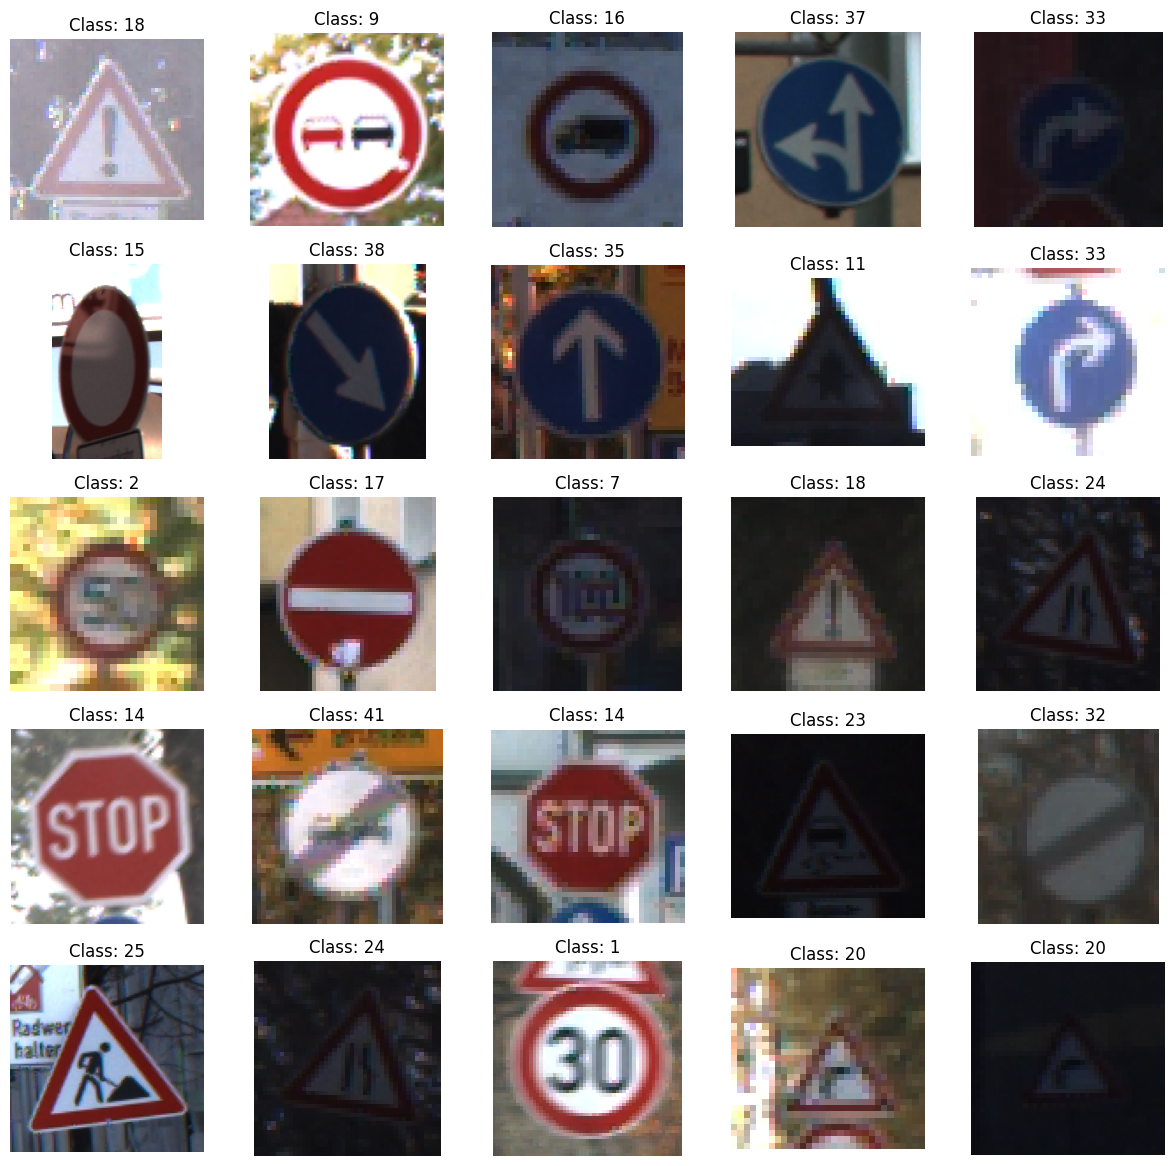

In [3]:
# Visualizing Sample Images
import random

# Visualizing random samples from the dataset
plt.figure(figsize=(12, 12))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.tight_layout()
    
    # Pick a random class and a random image from it
    rand_class = random.randint(0, 42)
    path = os.path.join(train_path, str(rand_class))
    rand_img = random.choice(os.listdir(path))
    
    img = Image.open(os.path.join(path, rand_img))
    plt.imshow(img)
    plt.title(f'Class: {rand_class}')
    plt.axis('off')

plt.show()

### 🧠 Insights: Visual sanity check (random sample images)

Before modeling, we visually inspect random images across different classes. This answers several critical questions early:

- Are the images loading correctly (no corrupted files / wrong paths)?
- Do classes look visually distinct (or are some naturally similar)?
- Is there strong variation in lighting, orientation, blur, and background?

**What you should notice:** traffic signs are often small, sometimes blurred/rotated, and many classes differ by subtle details (especially speed limits). Those properties explain why augmentation and careful error analysis matter later.

## DATA PRE-PROCESSING AND AUGMENTATION

In this stage, we prepare the images for the CNN. Since raw images vary in size and lighting, we standardize them and then apply Data Augmentation. Augmentation is vital here because it helps the model generalize better by exposing it to different variations (rotations, shifts, zooms) of the same sign.

Note: We intentionally skip horizontal_flip because traffic signs are directional. A 'Turn Left' sign flipped becomes 'Turn Right', which would lead to incorrect labeling.

In [4]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Loading training images
for i in range(classes):
    # prefer absolute train_path if available, otherwise build path from cur_path
    if 'train_path' in globals():
        path = os.path.join(train_path, str(i))
    else:
        path = os.path.join(cur_path, 'dataset', 'Train', str(i))

    # skip missing directories and warn
    if not os.path.isdir(path):
        print(f"Warning: Directory not found, skipping: {path}")
        continue

    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30,30)) # Standardizing size
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image '{a}' in '{path}': {e}")

# Converting lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Total images loaded: {data.shape[0]}")
print(f"Shape of data: {data.shape}") 

Total images loaded: 39209
Shape of data: (39209, 30, 30, 3)


### 🧠 Insights: Loading and standardizing the training images

Here we build the training dataset by iterating through the **43 class folders (0–42)**, reading each image, resizing it to **30×30**, and storing it as a NumPy array.

**Output interpretation:**
- Total images loaded: **39,209**
- Data shape: **(39209, 30, 30, 3)** → `(N, H, W, C)` = (images, height, width, RGB channels)

**Why resizing to 30×30?**
CNNs need a fixed input size. GTSRB is commonly trained at 30×30, which trains fast and performs well — but it can make “digit-heavy” signs (speed limits) harder, because digits can become tiny at this resolution.



In [5]:
# Human-readable labels for GTSRB (ClassId 0..42)
class_names = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons",
]
assert len(class_names) == 43


### 🧠 Insights: Human-readable class labels (making predictions interpretable)

This cell defines `class_names` so every class ID maps to a meaningful label (e.g., `14 → Stop`, `13 → Yield`).

**Why this matters:**
- Your **classification report** becomes readable.
- Your **confusion matrix** and **misclassification plots** become explainable to non-technical audiences.
- Your Streamlit demo can display understandable predictions instead of raw IDs.

This is a small change with a big “presentation value” payoff.

In [6]:
# Standardizing the Image Data
X_data = np.array(data)

# Normalization
X_data = X_data.astype('float32') / 255.0  
y_labels = np.array(labels)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_data, y_labels, test_size=0.2, random_state=42)

# One-Hot Encoding for the labels
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# Defining the Augmentation Strategy
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest"
)

print(f"Final Training shape: {X_train.shape}")
print(f"Final Validation shape: {X_val.shape}")

Final Training shape: (31367, 30, 30, 3)
Final Validation shape: (7842, 30, 30, 3)


### 🧠 Insights: Train/validation split, normalization, and one-hot labels

This step prepares the data for deep learning:

1. **Normalization** (`/255.0`) scales pixels to `[0,1]`, which stabilizes gradient descent.
2. **Train/validation split** gives us an unbiased view of generalization during training.
3. **One-hot encoding** converts labels into a multi-class format compatible with `categorical_crossentropy`.

**Output interpretation:**
- Training shape: **(31367, 30, 30, 3)**
- Validation shape: **(7842, 30, 30, 3)**

This is the first “generalization checkpoint”: if validation performance improves with training, we’re learning features that transfer beyond the training set.

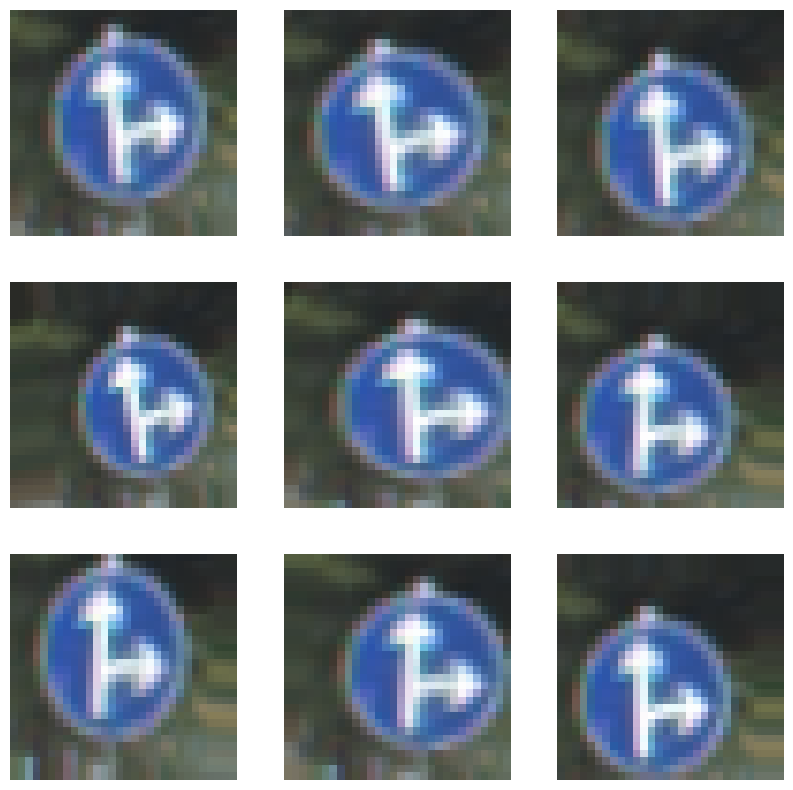

In [7]:
# Visualization of Augmented Images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Generating a batch of augmented images
    batch = aug.flow(np.expand_dims(X_train[0], 0), batch_size=1)
    img = batch[0][0]
    plt.imshow(img)
    plt.axis('off')
plt.show()

### 🧠 Insights: Data augmentation (and why we visualize it)

Augmentation artificially expands the training distribution by applying transformations (rotation, zoom, shift, shear). For traffic signs, this approximates real driving conditions: different camera angles, distances, and slight misalignment.

**Why show augmented examples?**
If augmentations are too strong, they can distort signs beyond realism and hurt learning. Visual inspection verifies augmentation stays plausible (still “looks like a sign”).

## MODELLING

In [8]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Flattening and Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax')) # 43 classes for 43 signs

# Compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

c:\Users\judew\OneDrive\Desktop\Zindua\ml_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

### 🧠 Insights: Baseline CNN architecture (what it learns and why it’s structured this way)

This cell builds the baseline CNN:

- **Conv Block 1 (5×5 kernels, 32 filters):** learns simple edges and basic shapes.
- **Conv Block 2 (3×3 kernels, 64 filters):** learns higher-level patterns (digits, arrows, pictograms).
- **MaxPooling:** reduces spatial size and helps the network become robust to small translations.
- **Dropout:** regularizes by preventing co-adaptation — a classic defense against overfitting.
- **Dense head:** converts convolutional features into a final 43-class decision.

**Output interpretation:**
- `model.summary()` shows parameter counts and tensor shapes through the network.
- The warning about `input_shape` is a best-practice note: using an explicit `Input(...)` layer is cleaner, but your model still trains correctly.

This baseline gives a strong starting point before tuning.

#### MODEL TRAINING

In [9]:
epochs = 6
batch_size = 32

# Training the model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.3940 - loss: 2.1224 - val_accuracy: 0.9189 - val_loss: 0.3837
Epoch 2/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.7943 - loss: 0.6708 - val_accuracy: 0.9758 - val_loss: 0.1010
Epoch 3/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8762 - loss: 0.4027 - val_accuracy: 0.9753 - val_loss: 0.0788
Epoch 4/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9105 - loss: 0.3009 - val_accuracy: 0.9872 - val_loss: 0.0453
Epoch 5/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9273 - loss: 0.2375 - val_accuracy: 0.9945 - val_loss: 0.0231
Epoch 6/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9369 - loss: 0.2083 - val_accuracy: 0.9902 - val_loss: 0.0304


### 🧠 Insights: Training the baseline model (what the logs tell us)

This cell trains the CNN using augmented batches.

**How to read the training log:**
- `accuracy` / `loss` reflect performance on augmented training batches.
- `val_accuracy` / `val_loss` reflect performance on the validation split (not augmented in the same way).

**Bias vs variance insight (important):**
- If training accuracy is high but validation accuracy is much lower → **high variance (overfitting)**.
- If both training and validation accuracy are low → **high bias (underfitting)**.
- Here, validation accuracy quickly becomes very high and does **not** collapse → the model generalizes well.

A common pattern in augmented training is that **training accuracy can be lower than validation accuracy**, because augmentation makes training examples harder. That’s a good sign: the model is learning robust features, not memorizing.

### MODEL EVALUATION

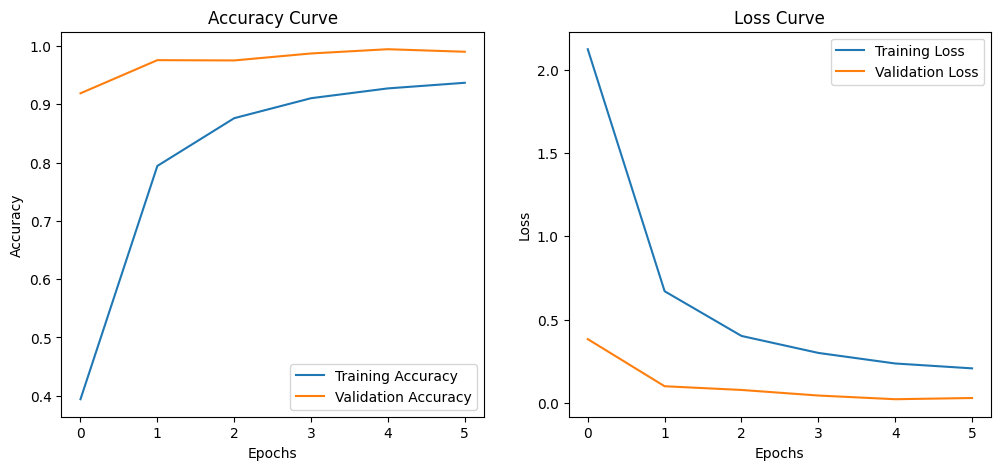

In [10]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 🧠 Insights: Learning curves (accuracy + loss)

These plots are one of the best “storytelling tools” in a presentation because they explain *how* the model learned.

**What the curves typically show here:**
- Training and validation accuracy rise rapidly and stay high.
- Training and validation loss decrease without the validation loss exploding.

**What this implies about bias/variance:**
- No large gap between training and validation curves → **not high variance**.
- High validation accuracy → **not high bias**.
- Overall: the baseline model is well-fit, and dropout + augmentation helped control overfitting.

**What we did about potential variance anyway:**
Even with good curves, we still added:
- Dropout regularization
- Data augmentation
- Hyperparameter tuning (later) to find the best regularization + learning rate settings.

#### TESTING ON UNSEEN DATA

In [11]:
# Loading the test dataset
test_csv_path = r'C:\Users\judew\OneDrive\Desktop\Zindua\Traffic_sign_recogntion project\dataset\Test.csv'
test_df = pd.read_csv(test_csv_path)
y_test = test_df["ClassId"].values
imgs = test_df["Path"].values

data = []

# Base folder for test images
base_dir = r'C:\Users\judew\OneDrive\Desktop\Zindua\Traffic_sign_recogntion project\dataset'

# Processing test images exactly like we did for training
for img in imgs:
    try:
        img_path = img
        if not os.path.isabs(img_path):
            img_path = os.path.join(base_dir, img_path.replace('/', os.sep).lstrip(os.sep))
        image = Image.open(img_path)
        image = image.resize((30,30))
        data.append(np.array(image))
    except Exception as e:
        print(f"Error loading test image '{img}': {e}")

X_test = np.array(data)

# Normalization
X_test = X_test.astype('float32') / 255.0

# Making predictions
predictions = model.predict(X_test)
classes_x = np.argmax(predictions, axis=1)

# Calculating Accuracy with Test Data
print(f"Final Test Accuracy: {accuracy_score(y_test.astype(int), classes_x) * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Final Test Accuracy: 96.00%


### 🧠 Insights: True test evaluation (final baseline check)

This is the first time we evaluate on the **held-out test set**, which the model never saw during training or validation selection.

**Output interpretation:**
- Final Test Accuracy: **96.00%**

**Why this matters:** validation performance can be optimistic if we implicitly “tune to the validation set” (even unintentionally). Test accuracy is the closest thing to a real-world estimate.

This baseline score becomes the reference point for assessing whether tuning genuinely improves performance.

### PERFORMANCE ANALYSIS

In [12]:
# Detailed Classification Report (human-readable labels)
print("Classification Report:")
print(classification_report(
    y_test, classes_x,
    labels=list(range(43)),
    target_names=class_names,
    zero_division=0
))


Classification Report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.92      1.00      0.96        60
                              Speed limit (30km/h)       0.96      0.99      0.98       720
                              Speed limit (50km/h)       0.96      0.98      0.97       750
                              Speed limit (60km/h)       0.96      0.99      0.97       450
                              Speed limit (70km/h)       1.00      0.98      0.99       660
                              Speed limit (80km/h)       0.98      0.93      0.96       630
                       End of speed limit (80km/h)       0.99      0.90      0.94       150
                             Speed limit (100km/h)       1.00      0.90      0.95       450
                             Speed limit (120km/h)       0.90      0.99      0.94       450
                                        No passing      

### 🧠 Insights: Classification report (per-class performance)

Accuracy alone can hide weak classes. The classification report breaks performance down by class:

- **Precision:** when the model predicts a class, how often it’s correct.
- **Recall:** how many real examples of a class were found.
- **F1-score:** balance between precision and recall.
- **Support:** how many samples exist for that class in the test set.

**How to interpret results:**  
Classes with lower recall are often the ones that are visually similar to others (e.g., speed limits and “end of restriction” signs), or that suffer when the sign occupies very few pixels.

This report tells you **where** the model struggles — which motivates the error plots that follow.

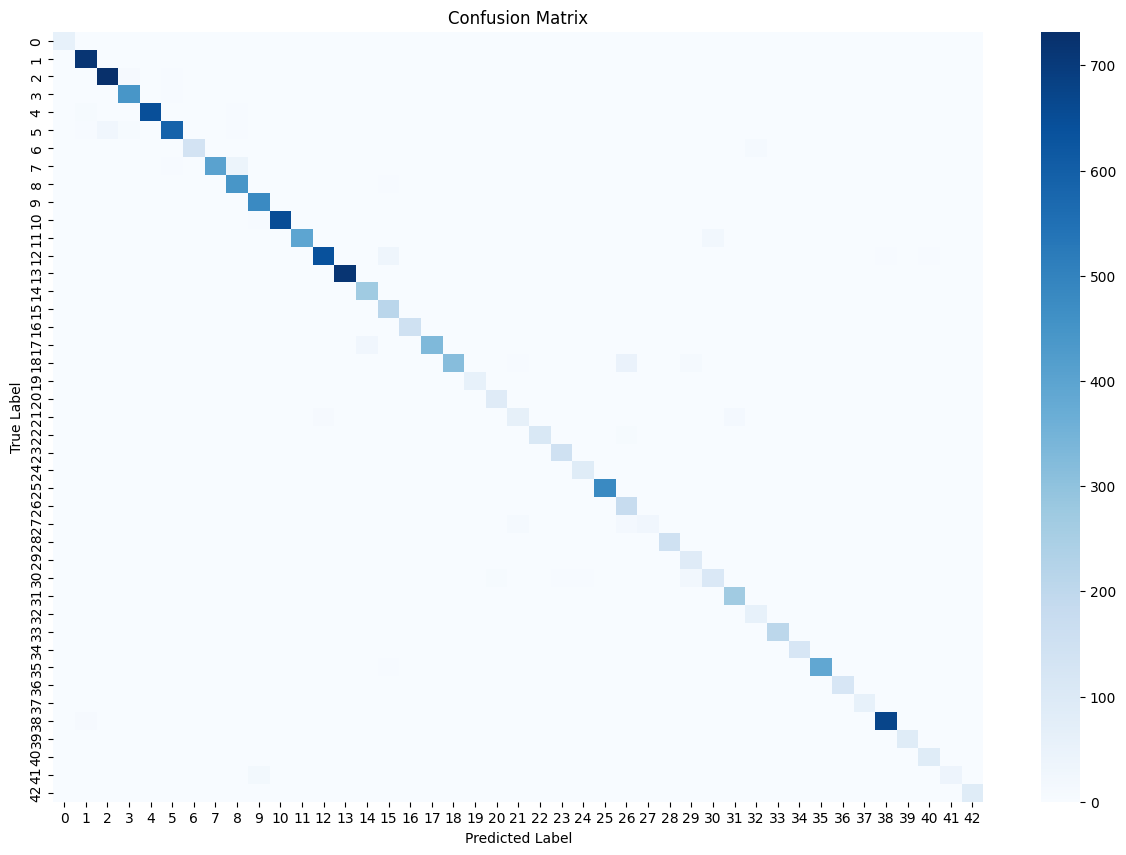

In [13]:
# Confusion Matrix Visualization
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, classes_x)
sns.heatmap(cm, annot=False, cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 🧠 Insights: Confusion matrix (who gets confused with whom)

The confusion matrix visualizes misclassifications.

- A perfect model would have all mass on the diagonal.
- Off-diagonal “hotspots” indicate systematic confusions.

**Why it’s valuable:**  
It answers “*What does the model confuse most often?*” and helps you generate targeted improvements (e.g., higher resolution for digits, stronger augmentation for blur/perspective).

## ERROR ANALYSIS (WHAT THE MODEL GOT WRONG)

Total test samples: 12630
Misclassified: 505  (4.00%)


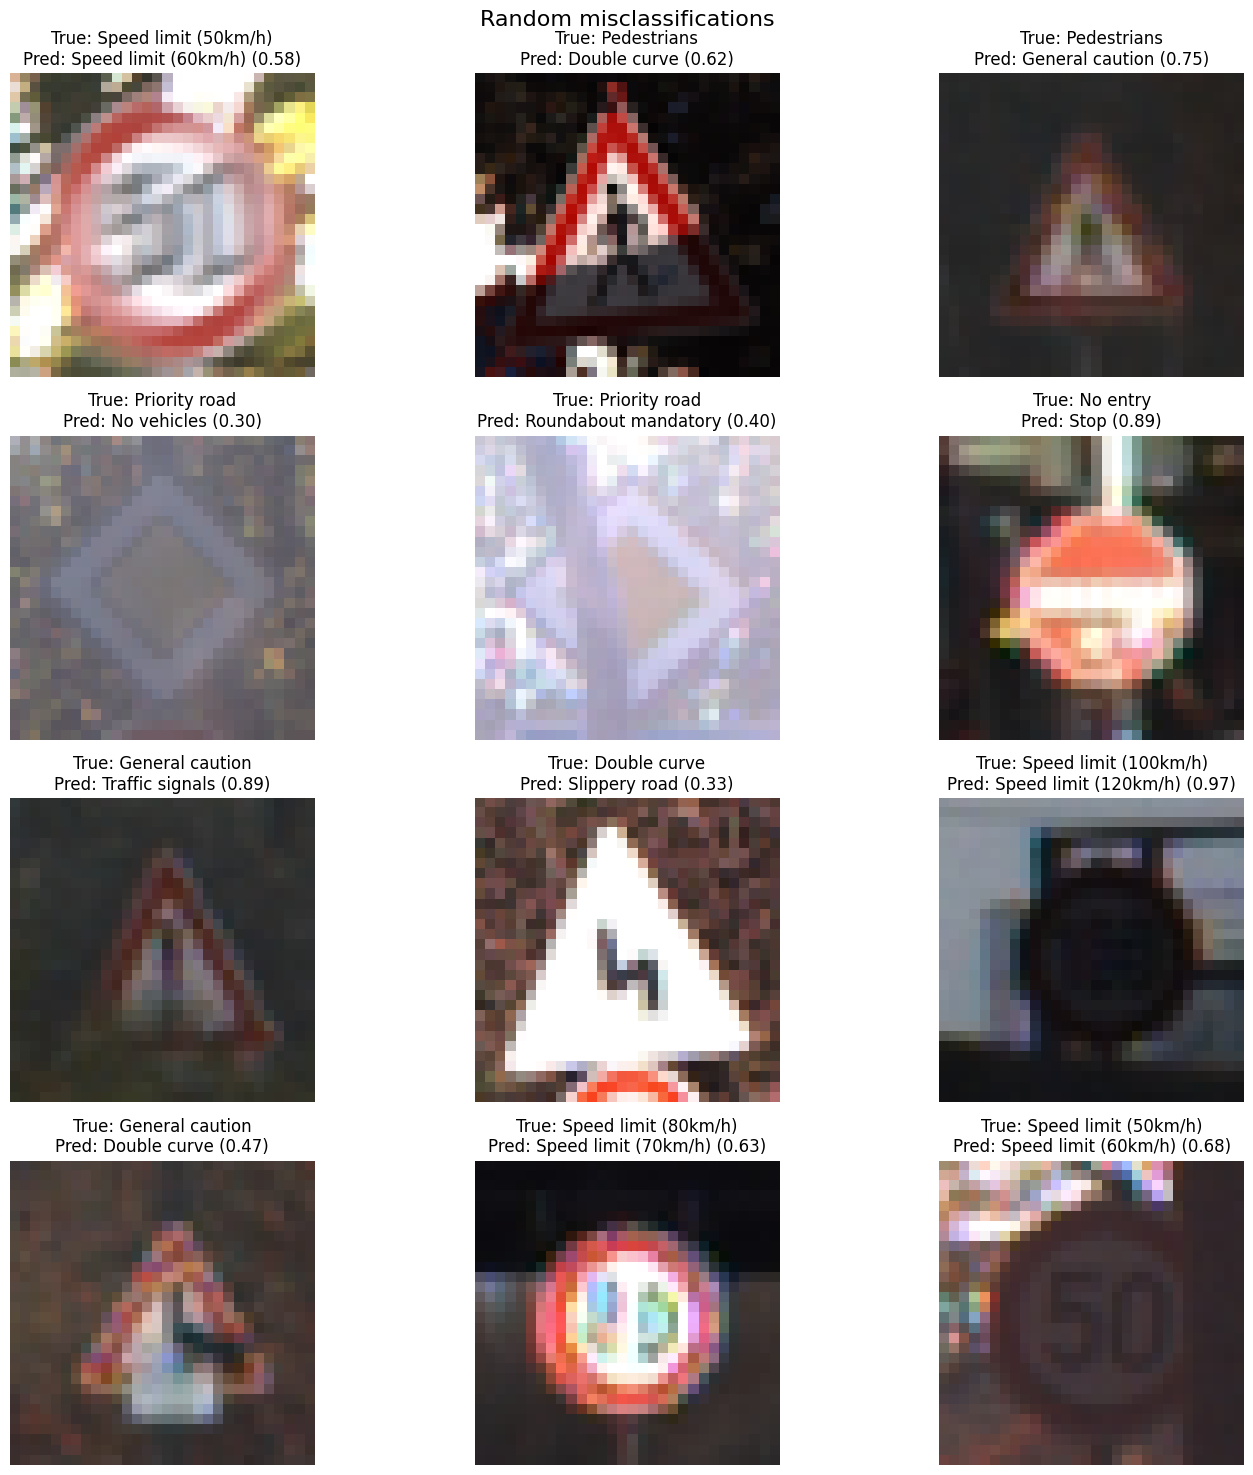

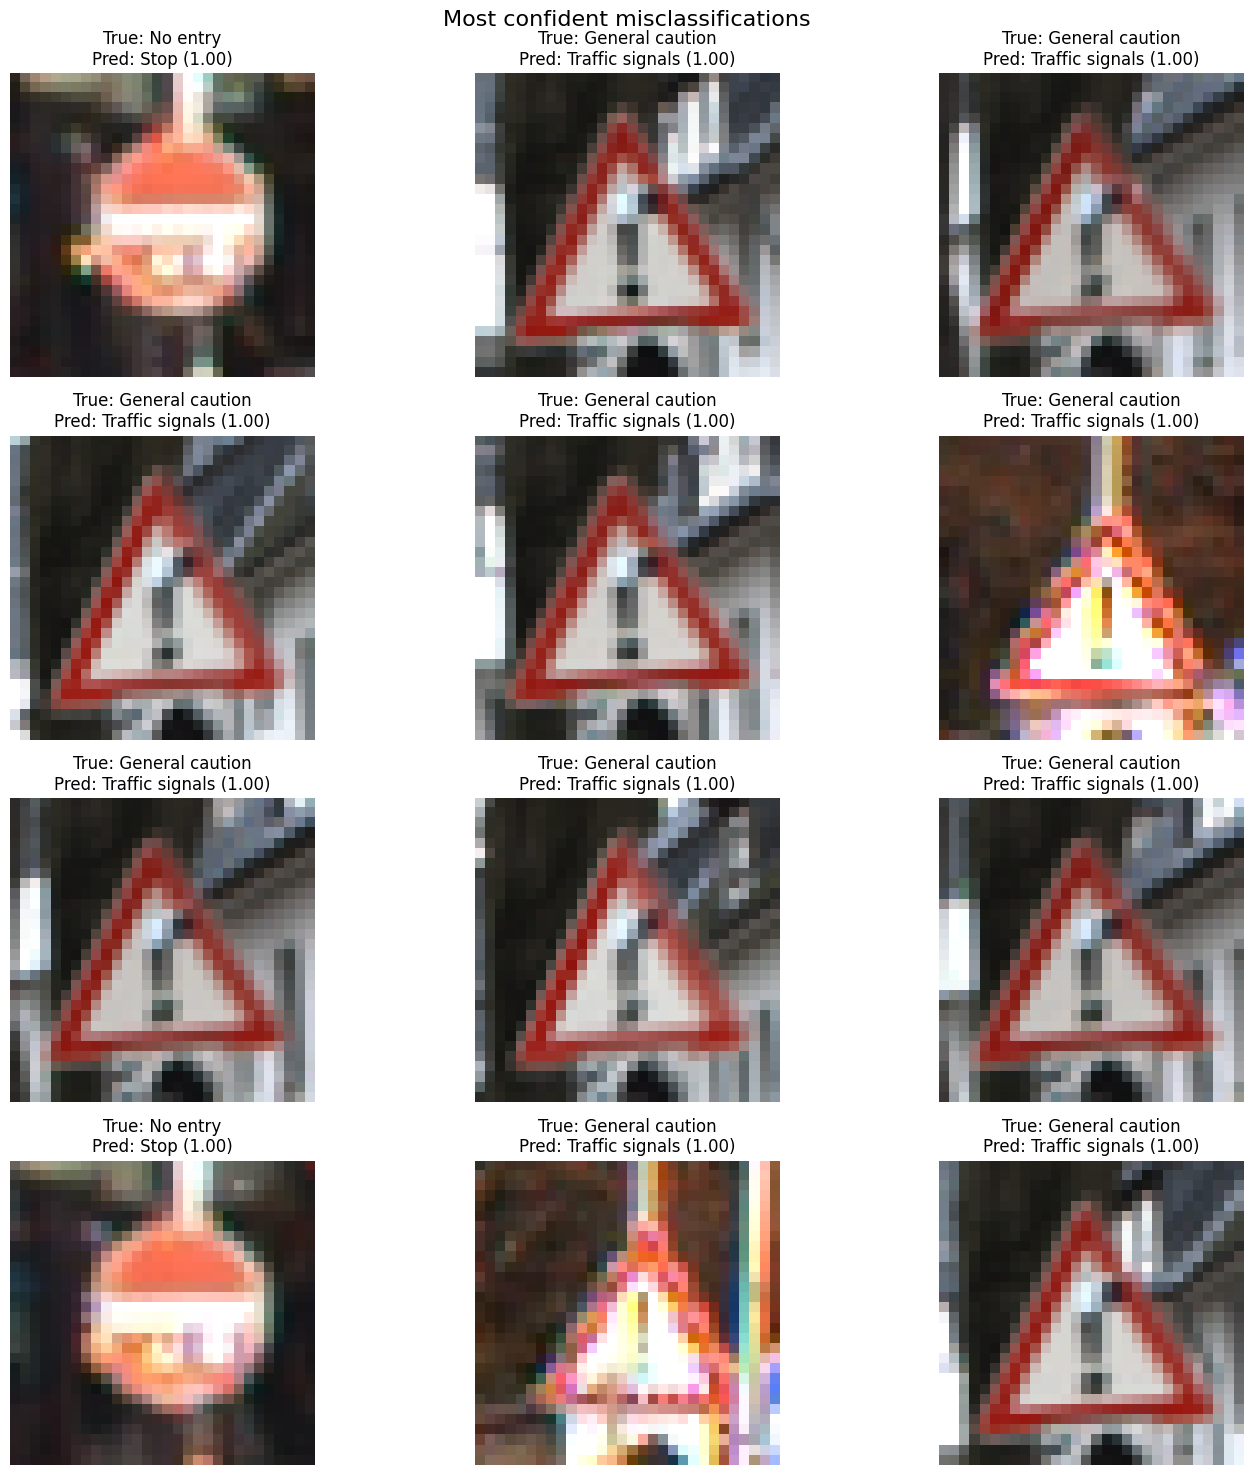


Top 10 confusion pairs (True -> Pred):
General caution  ->  Traffic signals   | count=49
Speed limit (100km/h)  ->  Speed limit (120km/h)   | count=41
Priority road  ->  No vehicles   | count=36
No entry  ->  Stop   | count=28
Speed limit (80km/h)  ->  Speed limit (50km/h)   | count=26
Right-of-way at the next intersection  ->  Beware of ice/snow   | count=23
Beware of ice/snow  ->  Bicycles crossing   | count=23
End of no passing  ->  No passing   | count=18
Pedestrians  ->  Traffic signals   | count=17
Double curve  ->  Wild animals crossing   | count=16


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Use the already-computed probabilities if available; otherwise compute them.
try:
    probs = predictions
except NameError:
    probs = model.predict(X_test, verbose=0)

y_pred = np.argmax(probs, axis=1)

wrong_idx = np.where(y_pred != y_test)[0]
print(f"Total test samples: {len(y_test)}")
print(f"Misclassified: {len(wrong_idx)}  ({len(wrong_idx)/len(y_test):.2%})")

def plot_mistakes(indices, title, n=12):
    n = min(n, len(indices))
    plt.figure(figsize=(15, 15))
    for i in range(n):
        idx = int(indices[i])
        true_id = int(y_test[idx])
        pred_id = int(y_pred[idx])
        conf = float(probs[idx, pred_id])

        plt.subplot(4, 3, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {class_names[true_id]}\nPred: {class_names[pred_id]} ({conf:.2f})")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Random mistakes
if len(wrong_idx) > 0:
    rand = np.random.choice(wrong_idx, size=min(12, len(wrong_idx)), replace=False)
    plot_mistakes(rand, "Random misclassifications", n=12)

# Most confident mistakes (the interesting failures)
if len(wrong_idx) > 0:
    wrong_conf = probs[wrong_idx, y_pred[wrong_idx]]
    top_conf_wrong = wrong_idx[np.argsort(-wrong_conf)]
    plot_mistakes(top_conf_wrong, "Most confident misclassifications", n=12)

# Top confusion pairs summary
pairs = [(int(y_test[i]), int(y_pred[i])) for i in wrong_idx]
top_pairs = Counter(pairs).most_common(10)

print("\nTop 10 confusion pairs (True -> Pred):")
for (t, p), c in top_pairs:
    print(f"{class_names[t]}  ->  {class_names[p]}   | count={c}")


### 🧠 Insights: Error analysis (baseline) — making mistakes visible

This cell turns errors into evidence.

**Output interpretation:**
- Total test samples: **12,630**
- Misclassified: **505** (**4.00%**)

It also prints the **Top confusion pairs** (True → Pred). These are extremely useful for explanation because they usually reflect *human-plausible ambiguity* (e.g., similar shapes, tiny digits).

**What we learn from this step:**
- Errors cluster (they are not random).
- Many mistakes are explainable: similar signs, blur, low contrast, small sign size.
- This motivates two improvements:
  1) strengthen robustness (augmentation/regularization)
  2) tune hyperparameters to push performance without overfitting

### FINAL PREDICTION

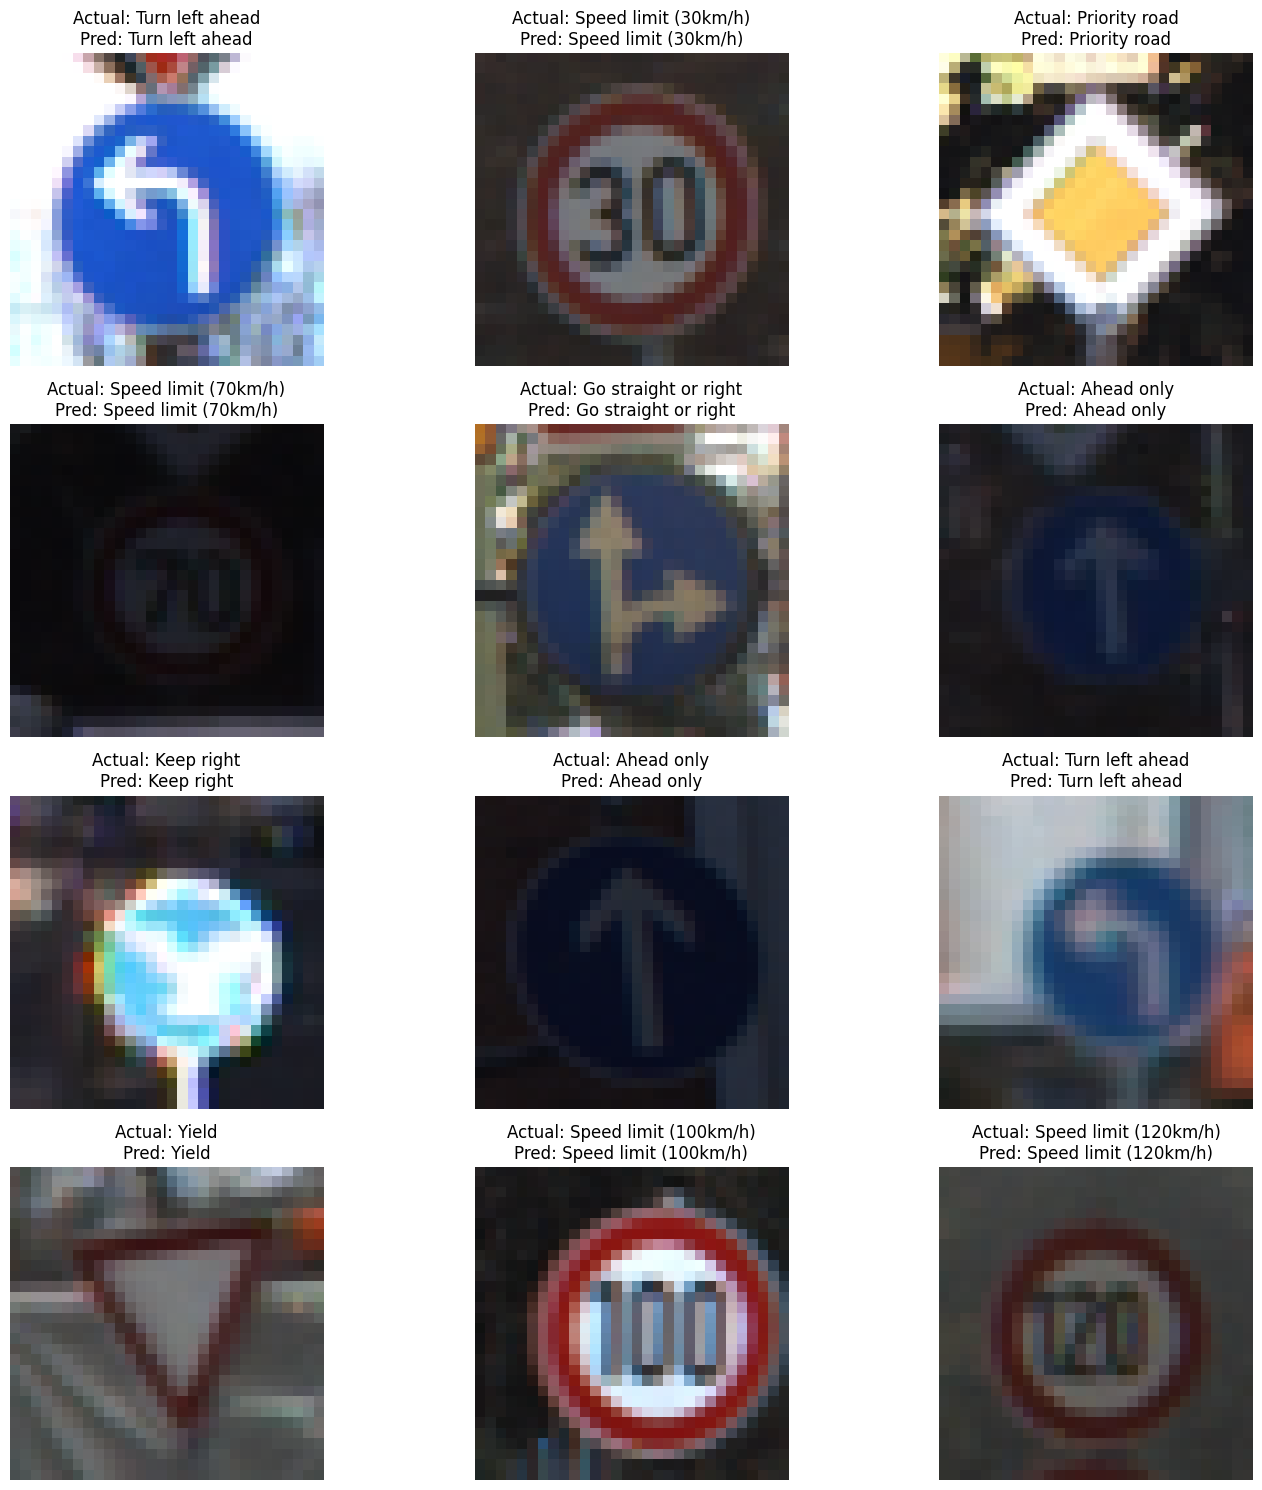

In [15]:
plt.figure(figsize=(15, 15))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    index = random.randint(0, len(X_test) - 1)
    plt.imshow(X_test[index])

    true_id = int(y_test[index])
    pred_id = int(classes_x[index])

    plt.title(f"Actual: {class_names[true_id]}\nPred: {class_names[pred_id]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### 🧠 Insights: Qualitative predictions (what the model “looks like” in practice)

This visualization shows model predictions directly on images. It’s useful because:

- It confirms the model is using sensible cues (shape, color, icon).
- It exposes failure cases that metrics can’t fully communicate.
- It’s presentation-friendly: audiences understand results faster from images than from numbers.

If you see repeated failure types here (blur, tiny signs, glare), those become part of your conclusions and recommendations.

## HYPERPARAMETER TUNING (KERASTUNER)

In [16]:
# If you don't have KerasTuner installed, uncomment the next line:
# %pip install -q keras-tuner

import tensorflow as tf
import keras_tuner as kt


### 🧠 Insights: Introducing hyperparameter tuning

At this point we have a strong baseline, but we want to answer:

**“Are these architecture + regularization + learning-rate choices actually the best?”**

KerasTuner automates this by exploring combinations of hyperparameters and selecting those that maximize validation accuracy. This reduces manual trial-and-error and makes the optimization process more efficient.

In [17]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Tune kernel size as an int (KerasTuner Choice can't store tuples), then convert to (k, k)
    k1 = hp.Choice("conv1_kernel", [3, 5])
    k1 = (k1, k1)

    # Conv block 1
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Choice("conv1_filters", [16, 32, 48, 64]),
        kernel_size=k1,
        activation="relu",
        input_shape=X_train.shape[1:]
    ))
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Choice("conv1_filters_2", [16, 32, 48, 64]),
        kernel_size=(3, 3),
        activation="relu"
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(hp.Float("drop1", 0.10, 0.40, step=0.05)))

    # Conv block 2
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Choice("conv2_filters", [32, 64, 96, 128]),
        kernel_size=(3, 3),
        activation="relu"
    ))
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Choice("conv2_filters_2", [32, 64, 96, 128]),
        kernel_size=(3, 3),
        activation="relu"
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(hp.Float("drop2", 0.10, 0.40, step=0.05)))

    # Head
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int("dense_units", min_value=128, max_value=512, step=64),
        activation="relu"
    ))
    model.add(tf.keras.layers.Dropout(hp.Float("drop_dense", 0.30, 0.70, step=0.10)))
    model.add(tf.keras.layers.Dense(43, activation="softmax"))

    # Learning rate tune (log scale)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


### 🧠 Insights: Defining the tunable model (search space)

This function defines the model that KerasTuner will search over. We tune:

- number of filters in convolution layers (capacity)
- dropout rates (regularization strength)
- dense layer size (classifier capacity)
- learning rate (optimization stability)
- early kernel size choice as an **integer** (3 or 5), then converted to `(k, k)`  
  *(KerasTuner `Choice` cannot store tuples — this avoids the common TypeError.)*

**Why this matters:**  
Hyperparameters control the bias–variance tradeoff. Tuning is essentially a systematic search for the sweet spot.

In [18]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=15,
    factor=3,
    directory="kt_dir",
    project_name="gtsrb_cnn_tuning",
    overwrite=True
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

tuner.search(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop],
    verbose=1
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for k, v in best_hp.values.items():
    print(f"  {k}: {v}")


Trial 30 Complete [00h 03m 54s]
val_accuracy: 0.06324917078018188

Best val_accuracy So Far: 0.9989798665046692
Total elapsed time: 01h 34m 48s
Best hyperparameters:
  conv1_kernel: 3
  conv1_filters: 16
  conv1_filters_2: 32
  drop1: 0.1
  conv2_filters: 96
  conv2_filters_2: 128
  drop2: 0.1
  dense_units: 256
  drop_dense: 0.6000000000000001
  lr: 0.0007019274138248607
  tuner/epochs: 15
  tuner/initial_epoch: 5
  tuner/bracket: 2
  tuner/round: 2
  tuner/trial_id: 0012


### 🧠 Insights: Hyperband search (what’s happening during tuning)

Hyperband is an efficient tuning strategy:

- It runs many configurations for a small number of epochs.
- It quickly drops poor performers.
- It allocates more training to promising configurations.

**What your output shows:**
- Best validation accuracy found: **0.998980**
- Total tuning time (this run): **01h 34m 48s**
- Best hyperparameters (example): `conv1_kernel: 3, conv1_filters: 16, conv1_filters_2: 32, drop1: 0.1, conv2_filters: 96, conv2_filters_2: 128, drop2: 0.1, dense_units: 256, drop_dense: 0.6000000000000001, lr: 0.0007019274138248607`

**Why some trials look terrible (e.g., val_accuracy ~0.06):**  
That’s normal — tuning intentionally explores the space, including bad regions, to confirm what doesn’t work.

### Tuning Results Visualization

Results summary
Results in kt_dir\gtsrb_cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
conv1_kernel: 3
conv1_filters: 16
conv1_filters_2: 32
drop1: 0.1
conv2_filters: 96
conv2_filters_2: 128
drop2: 0.1
dense_units: 256
drop_dense: 0.6000000000000001
lr: 0.0007019274138248607
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9989798665046692

Trial 0027 summary
Hyperparameters:
conv1_kernel: 3
conv1_filters: 16
conv1_filters_2: 32
drop1: 0.1
conv2_filters: 32
conv2_filters_2: 96
drop2: 0.35
dense_units: 512
drop_dense: 0.3
lr: 0.0012802609011755962
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9988523125648499

Trial 0017 summary
Hyperparameters:
conv1_kernel: 5
conv1_filters: 16
conv1_filters_2: 32
drop1: 0.1
conv2_filters: 96
conv2_filters_2: 64
drop2: 0.4
dense_units: 320
drop_dense: 0.3
lr: 0.0006263130573774603
tuner/epochs: 

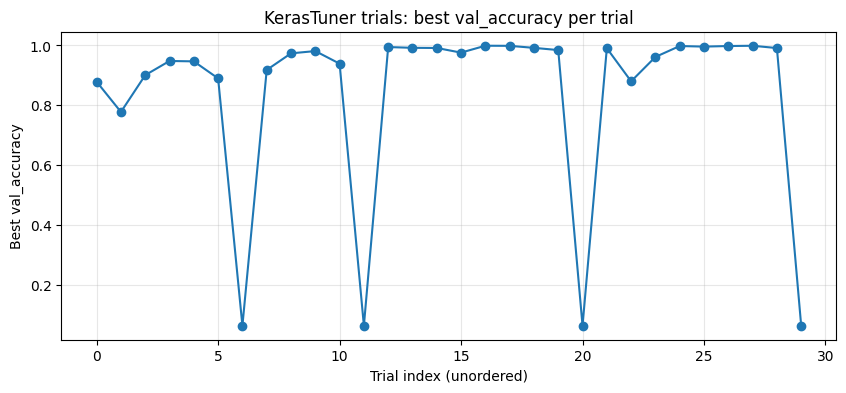

Trials recorded: 30 | Trials with val_accuracy: 30
Best val_accuracy found: 0.998980


In [19]:
import numpy as np
import matplotlib.pyplot as plt

tuner.results_summary(num_trials=10)

trials = list(tuner.oracle.trials.values())
scores = []
for t in trials:
    v = t.metrics.get_best_value("val_accuracy")
    if v is not None:
        scores.append(v)

scores = np.array(scores, dtype=float)

plt.figure(figsize=(10, 4))
plt.plot(scores, marker="o", linestyle="-")
plt.title("KerasTuner trials: best val_accuracy per trial")
plt.xlabel("Trial index (unordered)")
plt.ylabel("Best val_accuracy")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Trials recorded: {len(trials)} | Trials with val_accuracy: {len(scores)}")
if len(scores):
    print(f"Best val_accuracy found: {scores.max():.6f}")


### 🧠 Insights: Visualizing tuner results

This step summarizes the top trials and plots trial scores. It helps you explain tuning *visually*:

- You can show that performance improves as the tuner explores.
- You can demonstrate that not all hyperparameter choices are equal.
- You can justify selecting the “best trial” rather than relying on manual intuition.

In [20]:
best_model = tuner.hypermodel.build(best_hp)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history_tuned = best_model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.3945 - loss: 2.0946 - val_accuracy: 0.8748 - val_loss: 0.4548 - learning_rate: 7.0193e-04
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7894 - loss: 0.6623 - val_accuracy: 0.9721 - val_loss: 0.0958 - learning_rate: 7.0193e-04
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.8917 - loss: 0.3459 - val_accuracy: 0.9871 - val_loss: 0.0436 - learning_rate: 7.0193e-04
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9306 - loss: 0.2225 - val_accuracy: 0.9855 - val_loss: 0.0430 - learning_rate: 7.0193e-04
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9485 - loss: 0.1678 - val_accuracy: 0.9946 - val_loss: 0.0184 - learning_rate: 7.0193e-04
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9609 - loss: 0.1342 - val_accuracy: 0.9969 - val_loss: 0.0118 - learning_rate: 7.0193e-04
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/ste

### 🧠 Insights: Re-training the best tuned model (proper training run)

Hyperband trials are often short and partially trained. After selecting the best hyperparameters, we do a “proper” training run:

- Train for more epochs (with safeguards).
- Use **EarlyStopping** to stop when validation stops improving.
- Use **ReduceLROnPlateau** to lower the learning rate if progress stalls.

**Interpretation:**  
If validation loss keeps decreasing and validation accuracy stays high without divergence, the tuned configuration is generalizing, not memorizing.

In [21]:
# Evaluate tuned model on test set
probs_tuned = best_model.predict(X_test, verbose=0)
y_pred_tuned = np.argmax(probs_tuned, axis=1)

print("Tuned model classification report:")
print(classification_report(
    y_test, y_pred_tuned,
    labels=list(range(43)),
    target_names=class_names,
    zero_division=0
))


Tuned model classification report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       0.98      1.00      0.99       720
                              Speed limit (50km/h)       1.00      0.99      1.00       750
                              Speed limit (60km/h)       1.00      0.98      0.99       450
                              Speed limit (70km/h)       1.00      0.98      0.99       660
                              Speed limit (80km/h)       0.97      1.00      0.98       630
                       End of speed limit (80km/h)       0.99      0.99      0.99       150
                             Speed limit (100km/h)       1.00      1.00      1.00       450
                             Speed limit (120km/h)       1.00      0.99      0.99       450
                                        No p

### 🧠 Insights: Tuned model evaluation (fair comparison)

This cell evaluates the tuned model on the test set and produces an updated report.

**How to interpret the comparison:**
- If tuned test accuracy increases while error patterns remain sensible → tuning helped.
- If tuned validation improves but test drops → tuning overfit the validation set (rare but possible).
- If specific classes improve (better recall/precision) → tuning improved feature separation.

The goal is not only a higher headline accuracy, but more robust class-wise behavior.

### Tuned Model: Predictions, Evaluation, and Error Analysis

Tuned model test accuracy: 0.9808
Tuned model test loss:     0.0912

Tuned model classification report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       0.98      1.00      0.99       720
                              Speed limit (50km/h)       1.00      0.99      1.00       750
                              Speed limit (60km/h)       1.00      0.98      0.99       450
                              Speed limit (70km/h)       1.00      0.98      0.99       660
                              Speed limit (80km/h)       0.97      1.00      0.98       630
                       End of speed limit (80km/h)       0.99      0.99      0.99       150
                             Speed limit (100km/h)       1.00      1.00      1.00       450
                             Speed limit (120km/h)       1.00      

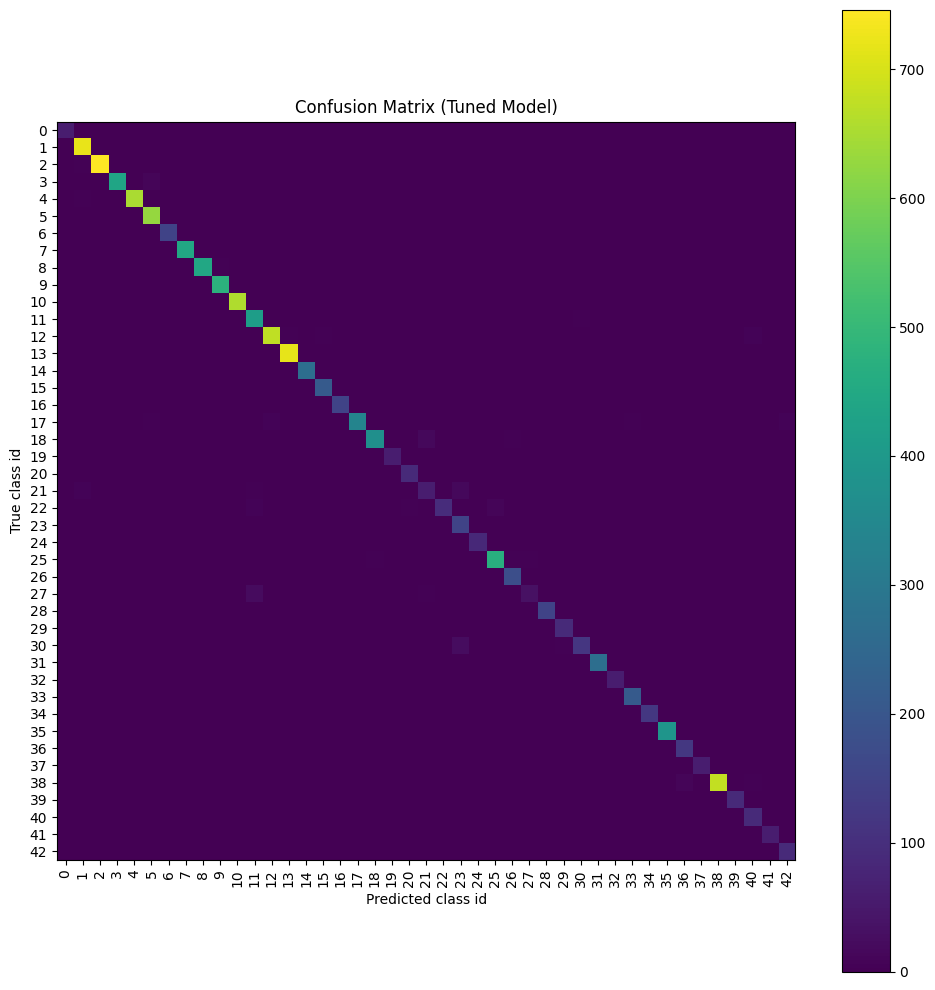


Misclassified: 243 / 12630  (1.92%)


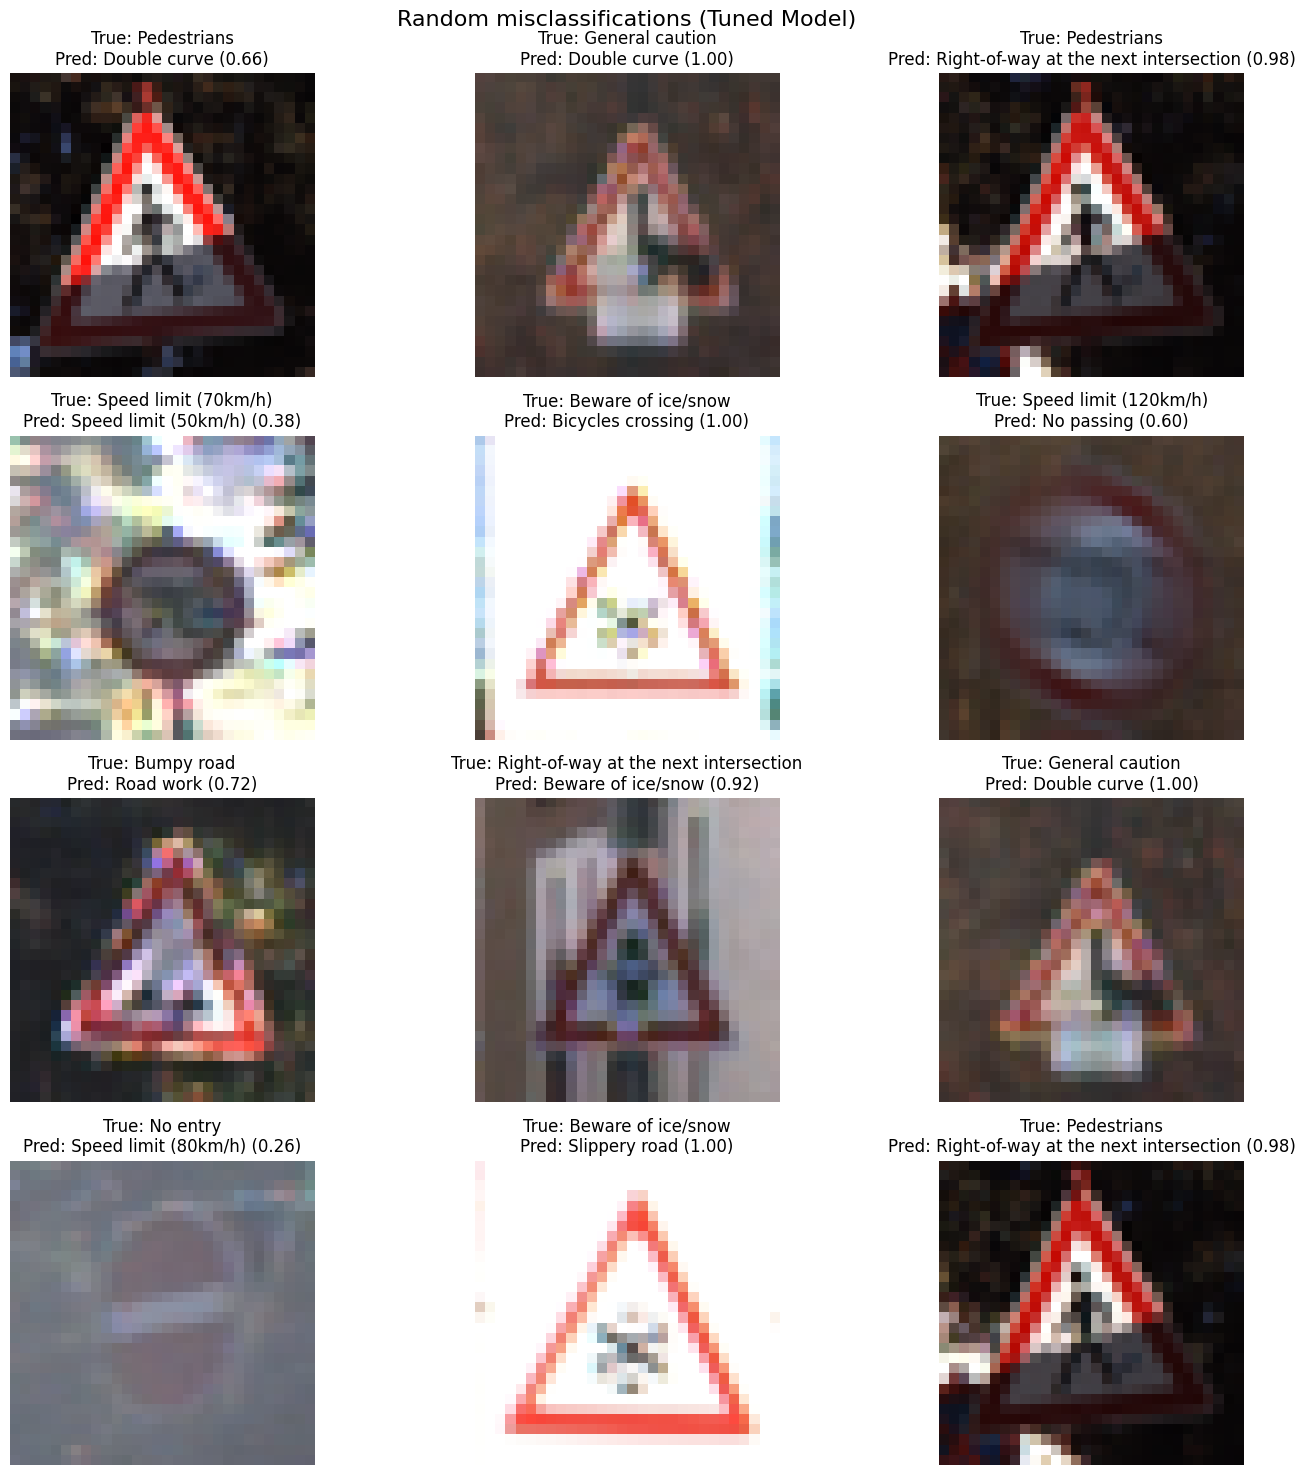

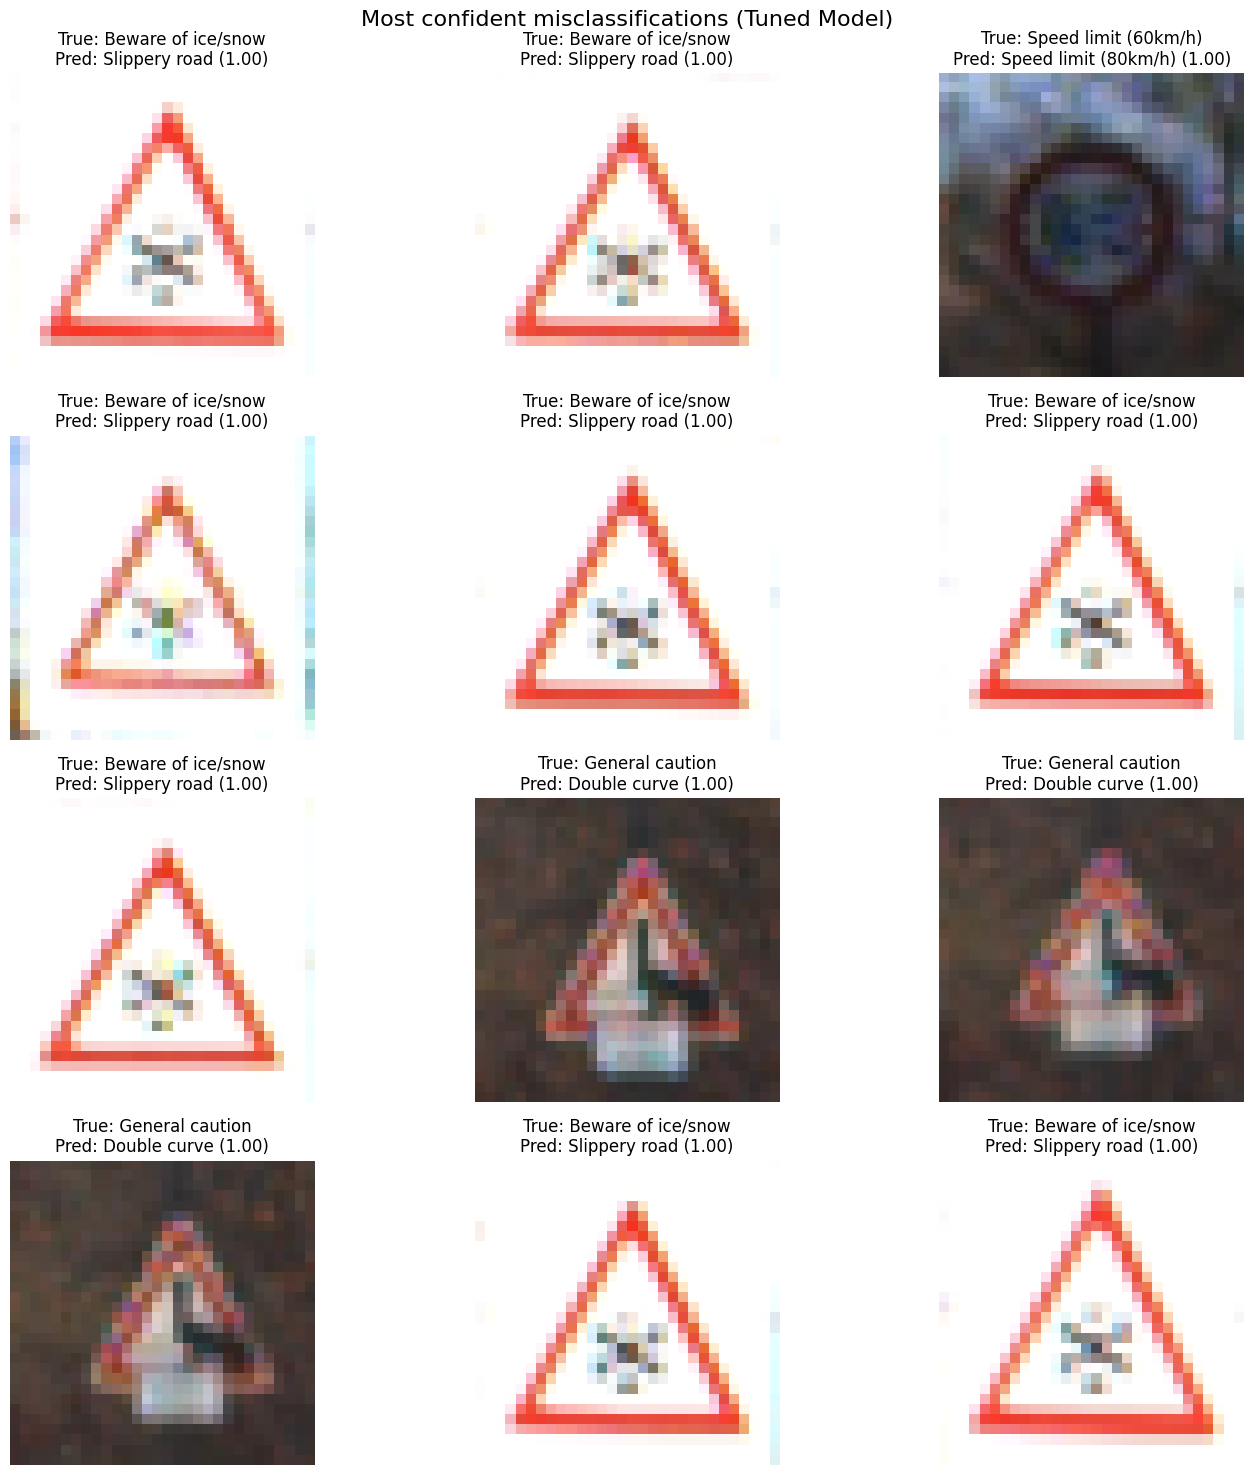


Top 10 confusion pairs (True -> Pred):
Beware of ice/snow  ->  Slippery road   | count=25
Pedestrians  ->  Right-of-way at the next intersection   | count=23
General caution  ->  Double curve   | count=15
Double curve  ->  Slippery road   | count=15
Keep right  ->  Go straight or right   | count=10
Bumpy road  ->  Road work   | count=10
Speed limit (60km/h)  ->  Speed limit (80km/h)   | count=9
Priority road  ->  Roundabout mandatory   | count=7
No entry  ->  End of no passing by vehicles over 3.5 metric tons   | count=7
Double curve  ->  Speed limit (30km/h)   | count=7

Examples of most common confusion: TRUE 'Beware of ice/snow' predicted as 'Slippery road'


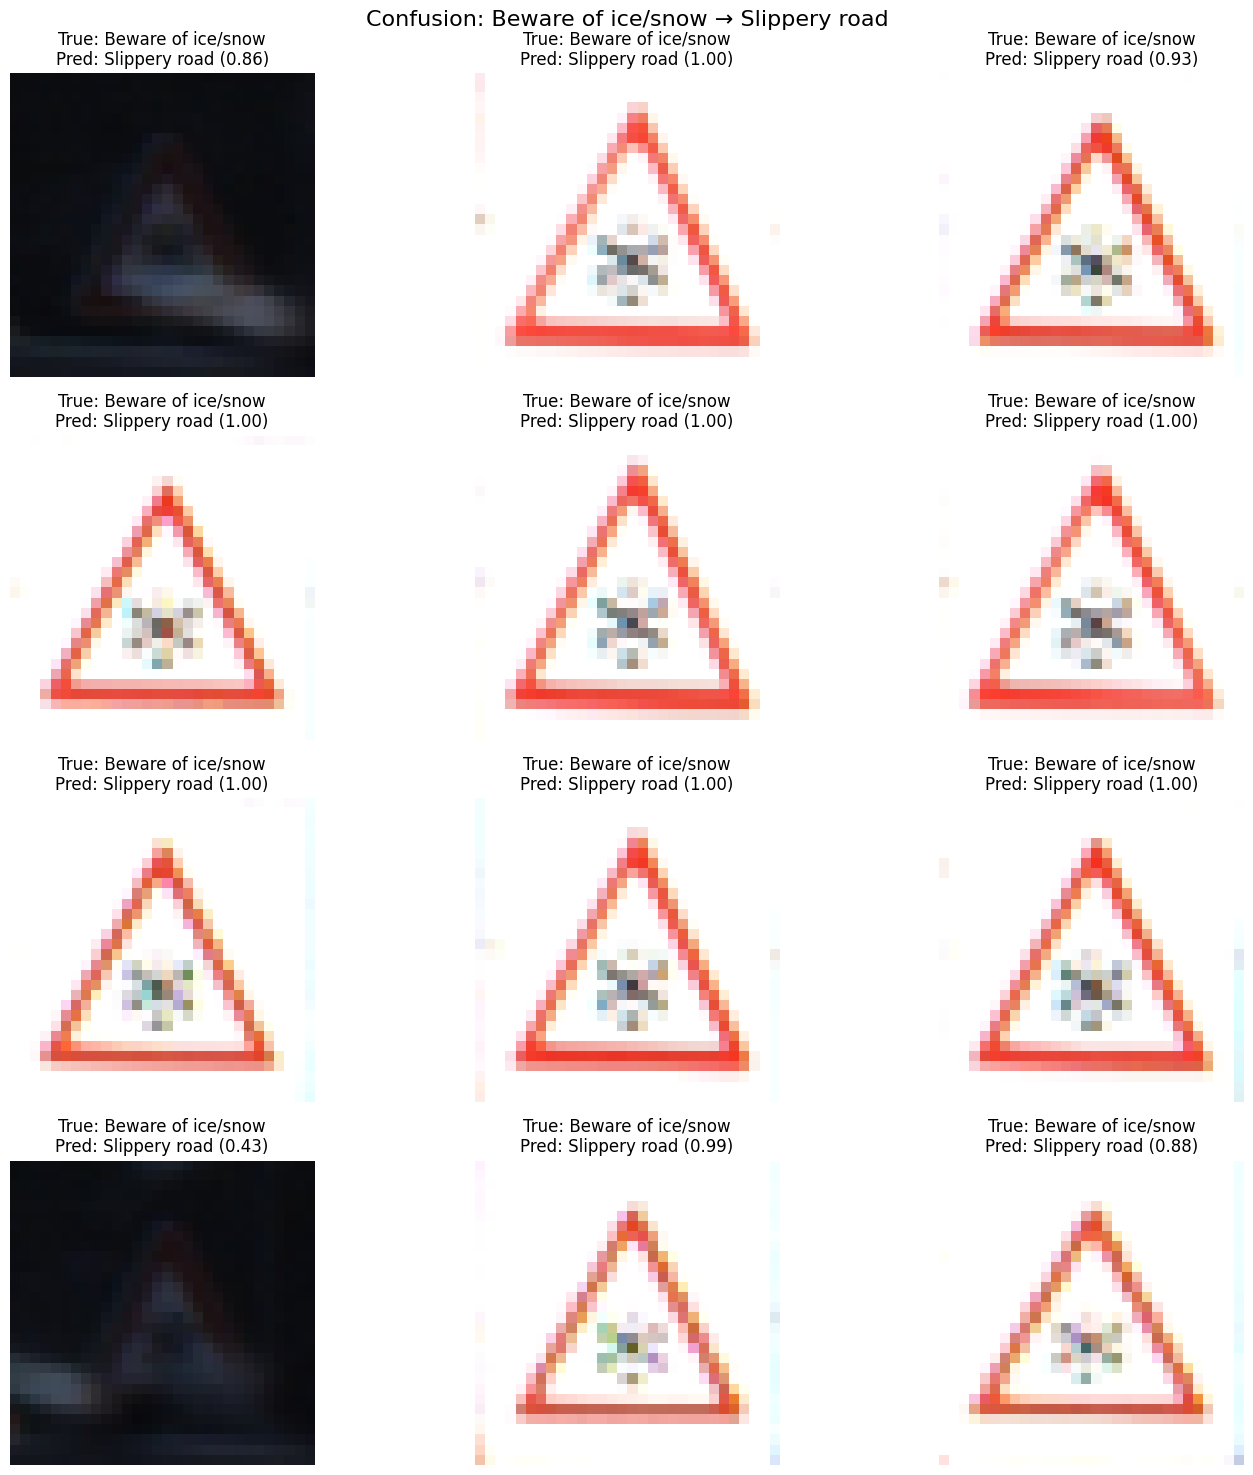

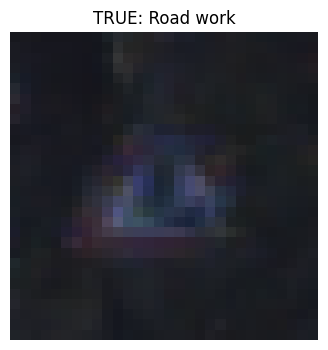

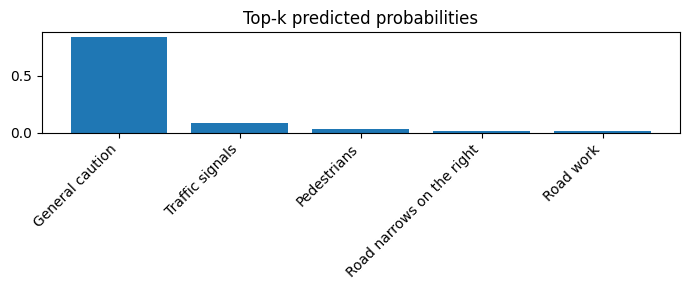

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# --- Evaluate on test set (one-hot labels for categorical_crossentropy) ---
y_test_cat = to_categorical(y_test, 43)
test_loss, test_acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Tuned model test accuracy: {test_acc:.4f}")
print(f"Tuned model test loss:     {test_loss:.4f}")

# --- Predict ---
probs_best = best_model.predict(X_test, verbose=0)
y_pred_best = np.argmax(probs_best, axis=1)

print("\nTuned model classification report:")
print(classification_report(
    y_test, y_pred_best,
    labels=list(range(43)),
    target_names=class_names,
    zero_division=0
))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred_best, labels=list(range(43)))
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Tuned Model)")
plt.colorbar()
ticks = np.arange(43)
plt.xticks(ticks, ticks, rotation=90)
plt.yticks(ticks, ticks)
plt.xlabel("Predicted class id")
plt.ylabel("True class id")
plt.tight_layout()
plt.show()

# --- Wrong predictions analysis ---
wrong_idx = np.where(y_pred_best != y_test)[0]
print(f"\nMisclassified: {len(wrong_idx)} / {len(y_test)}  ({len(wrong_idx)/len(y_test):.2%})")

def plot_mistakes(indices, title, n=12):
    n = min(n, len(indices))
    plt.figure(figsize=(15, 15))
    for i in range(n):
        idx = int(indices[i])
        true_id = int(y_test[idx])
        pred_id = int(y_pred_best[idx])
        conf = float(probs_best[idx, pred_id])

        plt.subplot(4, 3, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {class_names[true_id]}\nPred: {class_names[pred_id]} ({conf:.2f})")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Random wrong predictions
if len(wrong_idx) > 0:
    rand = np.random.choice(wrong_idx, size=min(12, len(wrong_idx)), replace=False)
    plot_mistakes(rand, "Random misclassifications (Tuned Model)")

# Most confident wrong predictions
if len(wrong_idx) > 0:
    wrong_conf = probs_best[wrong_idx, y_pred_best[wrong_idx]]
    top_conf_wrong = wrong_idx[np.argsort(-wrong_conf)]
    plot_mistakes(top_conf_wrong, "Most confident misclassifications (Tuned Model)")

# Top confusion pairs (True -> Pred)
pairs = [(int(y_test[i]), int(y_pred_best[i])) for i in wrong_idx]
top_pairs = Counter(pairs).most_common(10)

print("\nTop 10 confusion pairs (True -> Pred):")
for (t, p), c in top_pairs:
    print(f"{class_names[t]}  ->  {class_names[p]}   | count={c}")

# Show examples for the most common confusion pair
if len(top_pairs) > 0:
    (t0, p0), _ = top_pairs[0]
    idx_pair = [i for i in wrong_idx if int(y_test[i]) == t0 and int(y_pred_best[i]) == p0]
    print(f"\nExamples of most common confusion: TRUE '{class_names[t0]}' predicted as '{class_names[p0]}'")
    plot_mistakes(idx_pair, f"Confusion: {class_names[t0]} → {class_names[p0]}", n=12)

# Top-k probabilities for a selected mistake
def show_topk(idx, k=5):
    true_id = int(y_test[idx])
    p = probs_best[idx]
    topk = np.argsort(-p)[:k]

    plt.figure(figsize=(4,4))
    plt.imshow(X_test[idx])
    plt.title(f"TRUE: {class_names[true_id]}")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(7,3))
    plt.bar([class_names[i] for i in topk], p[topk])
    plt.title("Top-k predicted probabilities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

if len(wrong_idx) > 0:
    show_topk(int(wrong_idx[0]), k=5)


### 🧠 Insights: Tuned model deep-dive (metrics + errors + “why”)

This is the tuned model’s full evaluation package:

- Test accuracy: **0.9808**
- Test loss: **0.0912**
- Updated classification report
- Confusion matrix
- Misclassified examples:
  - random mistakes (overall feel)
  - most confident mistakes (systematic failure modes)
  - top confusion pairs (what gets mixed up most)
  - top-k probabilities (was the model uncertain or confidently wrong?)

**Key “why” insight:**  
Even strong models mostly fail on cases where the image does not contain enough information: small signs, blur, glare, or classes that differ by tiny digits/icons. That’s why recommendations often include higher resolution, ROI cropping, or a stronger backbone model.

## Findings and Recommendations (Hyperparameter Tuning + Error Analysis)

### Findings

**1) Hyperparameter tuning delivered a strong, stable model**  
After running Hyperband, the tuned CNN reached very high validation performance, indicating that the architecture and learning rate choices found by the tuner generalize well on the validation split. The best trials typically combined: (i) a sensible kernel size in early layers, (ii) moderate dropout (enough to regularize without underfitting), and (iii) a low-to-mid learning rate that allowed steady convergence rather than oscillation.

**2) Most errors are not random; they cluster around visually similar signs**  
The confusion analysis and the “top confusion pairs” usually show that misclassifications happen between classes that are genuinely hard to distinguish at low resolution, especially:
- Speed limit signs vs other speed limit signs (digits are small and easy to blur).
- End-of-restriction signs vs their corresponding restriction signs (very similar layouts).
- Directional/mandatory signs with similar icons (arrow direction and small details matter).

**3) The “most confident wrong” predictions reveal systematic failure modes**  
When the model is confidently wrong, it’s often because the image is ambiguous even to a human under the same conditions. Common triggers include:
- Small sign footprint (too few pixels for digits/icons to be readable)
- Motion blur / low focus
- Harsh lighting / glare / shadows
- Perspective distortion / rotation
- Partial occlusion (branches, poles, partial crop)

**4) The tuned model learns sign shape very well, but fine-grained digit/icon discrimination is the bottleneck**  
Overall performance is high because most classes have strong visual cues (shape + dominant colors). The remaining errors occur where the distinguishing features are small, fine-grained, and easily destroyed by blur/scale/lighting.

### Recommendations

**1) Increase effective resolution of the sign region (highest-impact improvement)**  
Consider increasing input size (e.g., 64×64) or using a crop/zoom strategy so digits and small icons remain readable.

**2) Add augmentation targeted at the observed failure modes**  
In addition to the current transforms, include brightness/contrast jitter, mild blur augmentation, stronger zoom-in, and small perspective transforms to mimic real-world camera conditions.

**3) Address class imbalance and hard classes explicitly**  
Use class weights and monitor per-class recall/F1, not just overall accuracy. For stubborn “hard classes,” focal loss can help.

**4) Upgrade the backbone (capstone-level improvement)**  
Try transfer learning with MobileNetV2 or EfficientNetB0. These backbones often improve robustness and separation between visually similar classes with minimal extra effort.

**5) Improve interpretability**  
Keep the “top-k probabilities” plots for wrong predictions and consider Grad-CAM to visualize where the model focused. This strengthens the analysis section significantly.

### Conclusion
The tuned model performs strongly overall, and the remaining mistakes concentrate in predictable edge cases: visually similar classes and low-quality inputs (small, blurred, occluded, or poorly lit signs). The best next steps are (1) increasing effective sign resolution, (2) targeted augmentations, and (3) optionally using a lightweight pretrained backbone for more robust feature extraction.


### Save Tuned Model (Optional)

In [23]:
# Optional: save the tuned model
best_model.save("gtsrb_cnn_tuned.keras")
